

This code is based on the functions provided in the following GitHub repositories:

- [wavenumber_frequency_functions.py](https://github.com/Blissful-Jasper/wavenumber_frequency/blob/master/wavenumber_frequency_functions.py)

- [wk_analysis.py](https://github.com/Blissful-Jasper/wk_spectra/blob/master/wk_spectra/wk_analysis.py)

- [spectrum.py](https://github.com/Blissful-Jasper/mcclimate/blob/master/spectrum.py)



- The adjustments made to the code focus on improving its computational speed. 

- While the results might slightly differ from those generated by the official NCL website or the original implementations in the aforementioned repositories, the extraction of symmetric and antisymmetric signals from the overall wave fluctuations is acceptable when compared to the NCL results.

- This version is a straightforward implementation, without extensive encapsulation, providing a good foundation for understanding the calculation process of the space-time spectrum. 

- The data used in this code can be obtained from the NOAA's Uninterpolated OLR Data, with daily mean data from 1997 to 2014 used in this code.

- [data used from here](https://psl.noaa.gov/data/gridded/data.uninterp_OLR.html)

 nDayTot: 6574.0, nSampWin: 96, nSampSkip: 30, nWindow: 52
Runtime: 2.0 seconds.


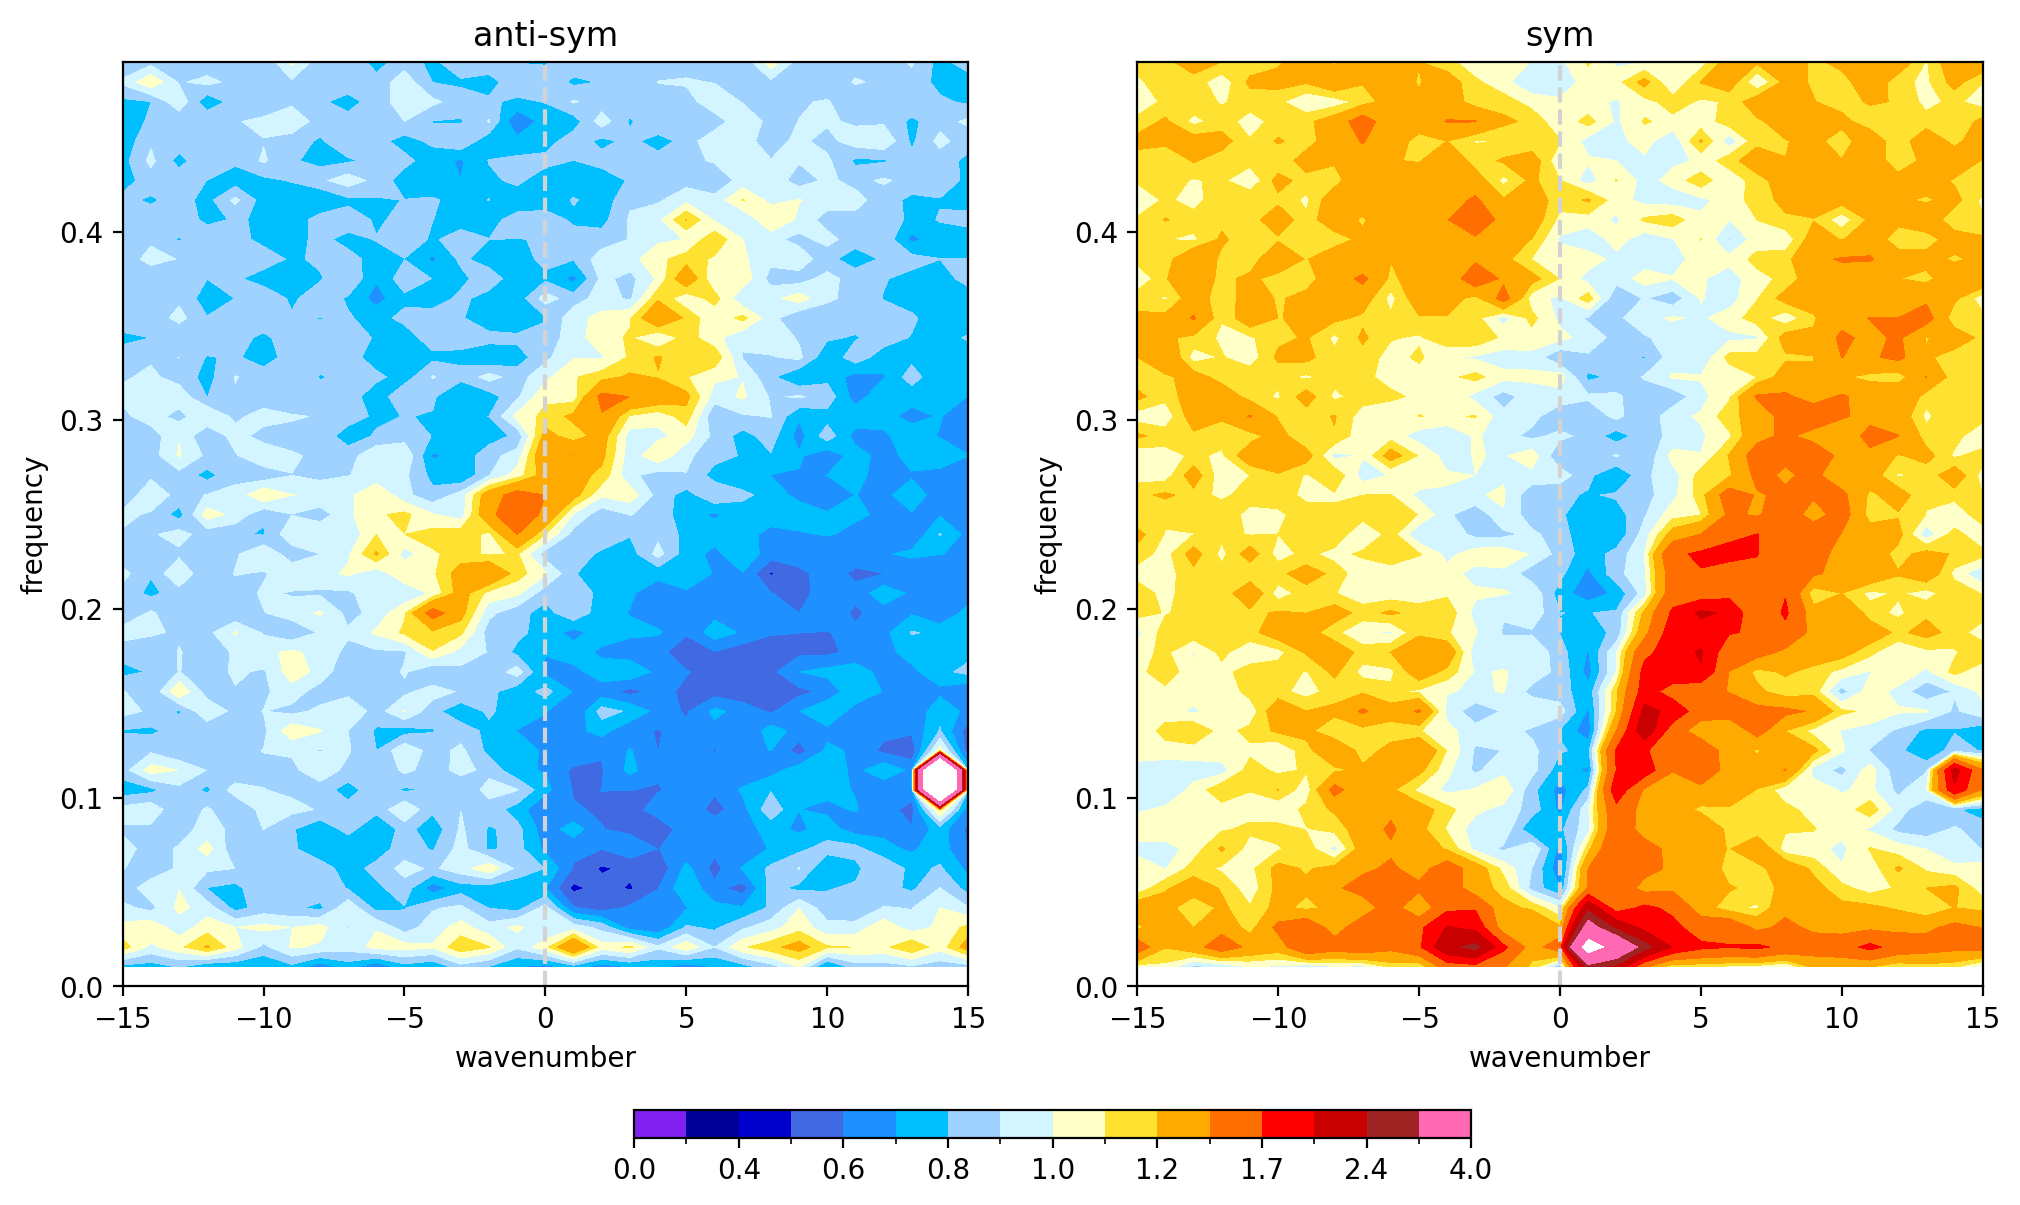

In [4]:

"""
@author: jianpu

@email : xianpuji@hhu.edu.cn

"""


import matplotlib.pyplot as plt
import cmaps
import numpy as np
import xarray as xr
import scipy.signal as signal
import math
import time
from scipy import fft

# ================ Global variable settings ===================
NA = np.newaxis
pi = math.pi
path = r"I://olr.day.mean.nc"
lat_range = [-15, 15]
time_range = ('1997', '2014')

# ================ load dataing  ===================
ds = xr.open_dataset(path).sortby('lat')
olr = ds.olr.sel(time=slice(*time_range), lat=slice(*lat_range)).sortby('lat').transpose('time', 'lat', 'lon')
datain = olr

ntim, nlat, nlon = datain.shape

# ================ Parameter settings ===================
nDayWin, nDaySkip = 96, 30
fCrit = 1.0 / nDayWin
spd = 1
nDayTot = ntim / spd
nSampWin = nDayWin * spd
nSampSkip = nDaySkip * spd
nWindow = int((nDayTot * spd - nSampWin) / (nSampWin + nSampSkip)) + 1

print(f" nDayTot: {nDayTot}, nSampWin: {nSampWin}, nSampSkip: {nSampSkip}, nWindow: {nWindow}")

# ================ function ===================
def decompose2SymAsym(X):
    (ntim,nlat,nlon)  = X.shape
    res = np.copy(X)
    for i in range(nlat//2):
        #  anti-symmetric part in the Southern Hemisphere
        res[:,i,:] = 0.5*(X[:,nlat-1-i,:] - X[:,i,:])
        #  symmetric part in the Northern Hemisphere
        res[:,nlat-1-i,:] = 0.5*(X[:,nlat-1-i,:] + X[:,i,:])
    return res


def remove_annual_cycle(data, samples_per_day, freq_cutoff):
    """Remove annual cycle (low frequency components)"""
    n_time, _, _ = data.shape
    detrended_data = signal.detrend(data, axis=0)  # 去趋势
    fourier_transform = fft.rfft(detrended_data, axis=0)
    frequencies = fft.rfftfreq(n_time, d=1. / float(samples_per_day))

    # 低频滤波
    cutoff_index = np.argwhere(frequencies <= freq_cutoff).max()
    if cutoff_index > 1:
        fourier_transform[1:cutoff_index + 1, ...] = 0.0

    return xr.DataArray(fft.irfft(fourier_transform, axis=0, n=n_time),
                        dims=olr.dims, coords=olr.coords)

def _smooth121(array):

    weight = np.array([1.,2.,1.])/4.0

    return np.convolve(np.r_[array[0],array,array[-1]],weight,'valid')


# ================ Data preprocessing ===================
start_time = time.time()

# detrend
xmean = datain.mean(dim='time')
xdetr = signal.detrend(datain, axis=0, type='linear')
xdetr = xr.DataArray(xdetr, dims=datain.dims, coords=datain.coords) + xmean

# Remove annual cycle
datain = remove_annual_cycle(xdetr, spd, fCrit)

# Compute symmetric and antisymmetric components
datain = decompose2SymAsym(datain)

# 
sumpower = np.zeros((nSampWin, nlat, nlon))
taper = 'tukey'

# ================ Computing the space-time spectrum ===================
ntStrt, ntLast = 0, nSampWin

for nw in range(int(nWindow)):
    data = datain[ntStrt:ntLast, :, :]
    data = signal.detrend(data, axis=0)

    if taper == 'tukey':
        window = signal.windows.tukey(nSampWin, 0.1, True)
        data *= window[:, NA, NA]

    power = fft.fft2(data, axes=(0, 2)) / (nlon * nSampWin)
    sumpower += np.abs(power) ** 2

    ntStrt = ntLast+nSampSkip          #; set index for next temporal window
    ntLast = ntStrt+nSampWin  

sumpower /= nWindow

# ================ Calculation of background spectrum ===================
if nlon % 2 == 0:
    wavenumber = fft.fftshift(fft.fftfreq(nlon) * nlon)[1:]
    sumpower = fft.fftshift(sumpower, axes=2)[:, :, nlon:0:-1]
else:
    wavenumber = fft.fftshift(fft.fftfreq(nlon) * nlon)
    sumpower = fft.fftshift(sumpower, axes=2)[:, :, ::-1]

frequency = fft.fftshift(fft.fftfreq(nSampWin, d=1. / float(spd)))[nSampWin // 2:]
sumpower = fft.fftshift(sumpower, axes=0)[nSampWin // 2:, :, :]

power_symm = 2.0 * sumpower[:, nlat // 2:, :].sum(axis=1)
power_anti = 2.0 * sumpower[:, :nlat // 2, :].sum(axis=1)

power_symm = xr.DataArray(power_symm, 
                          dims=("frequency","wavenumber",), 
                     coords={
                             "wavenumber":wavenumber,
                             "frequency":frequency})
power_anti = xr.DataArray(power_anti, 
                          dims=("frequency","wavenumber",), 
                     coords={
                             "wavenumber":wavenumber,
                             "frequency":frequency})

background = sumpower.sum(axis=1)

power_symm[0, :] =  np.ma.masked
power_anti[0, :] =  np.ma.masked
background[0, :] =  np.ma.masked

# Smooth background spectrum
wave_smooth_indices = np.where(np.abs(wavenumber) <= 20)[0]

for idx, freq in enumerate(frequency):
    if freq <0.1:
        smooth_iterations = 5
    elif freq >= 0.1 and freq < 0.2:
        smooth_iterations = 10
    elif freq >= 0.2 and freq < 0.3:
        smooth_iterations = 20
    elif freq >= 0.3:
        smooth_iterations = 40
    for _ in range(smooth_iterations):
        background[idx, wave_smooth_indices] = _smooth121(background[idx, wave_smooth_indices])

for wave_idx in wave_smooth_indices:
    for _ in range(10):
        background[:, wave_idx] = _smooth121(background[:, wave_idx])
        
print(f"Runtime: {time.time() - start_time:.1f} seconds.")

# ================ plot result ===================
cmap = cmaps.amwg_blueyellowred
level = np.array([0,.3, .4, .5, .6, .7, .8, .9, 1., 1.1, 1.2, 1.4, 1.7, 2., 2.4, 2.8, 4])

fig, axs = plt.subplots(1, 2, figsize=(12, 8), dpi=200)

cb0 = (power_anti / background).plot.contourf(ax=axs[0], levels=level, cmap=cmap, add_colorbar=False,extend='neither',)
cb1 = (power_symm / background).plot.contourf(ax=axs[1], levels=level, cmap=cmap, add_colorbar=False,extend='neither',)
axs[1].set_title('sym')
axs[0].set_title('anti-sym')
for ax in axs:
    ax.axvline(0, linestyle='dashed', color='lightgray')
    ax.set_xlim([-15, 15])

fig.colorbar(cb0, ax=[axs[0], axs[1]], orientation='horizontal', shrink=0.45, aspect=30, pad=0.1)
plt.show()
plt.close()



here is result from NCL output:


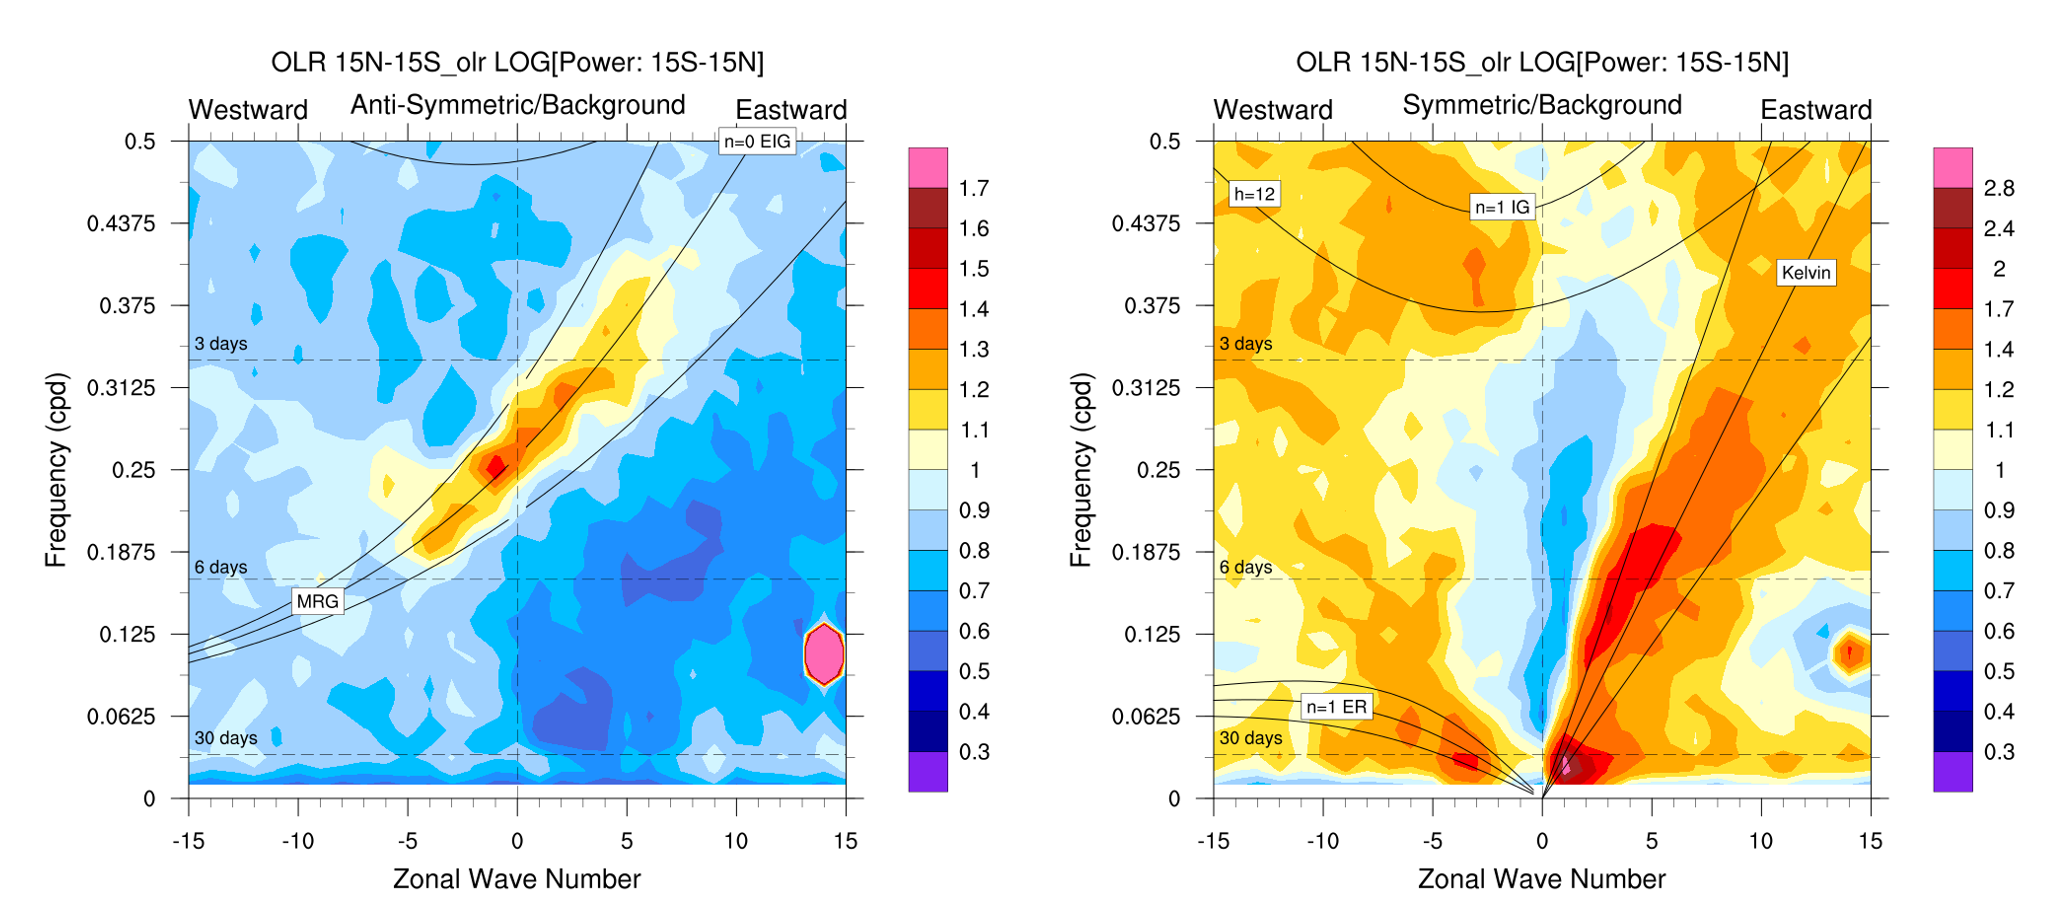